In [3]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
from matplotlib.widgets import Cursor

from pathlib import Path
import sys

import xarray as xr
import os as os
import glob
import matplotlib.gridspec as gridspec
import metpy.calc as mpcalc
from metpy.units import units
import pickle

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import metpy
from metpy import constants


In [4]:
import datetime
#--------------------------------------------------------------------------------------------------
# my datetime stuff
def my_datetime(input: list, time_delta=None, format=None, summary_file=False):

    """
        Inputs: input (list) list of [YY, MM, DD, HH, MM, SS]

                time_delta: (list)  -> [hours, minutes, seconds]
                                
                                or
                                    ->  [Days, hours, minutes, seconds]
                                    
                format:  (string)   ->  '%Y-%m-%d::%H-%M'
                
                                or
                                    ->  '%Y%d_%H%M'  (usefull for WoFS files)

        returns:  Datetime object or string if format is supplied.
        
    """
    try:
        hhmm = datetime.datetime(*input)
    except ValueError:
        print(f"Input is invalid, need YYMMDDHHMM {input}")
        return None
        
    if time_delta == None:
        
        if format == None:
            return hhmm
        else:
            return hhmm.strftime(format)
    
    else:
        
        if len(time_delta) == 3:
            timeD = datetime.timedelta(days=time_delta[0], hours=time_delta[1], minutes=time_delta[2])
        else:
            timeD = datetime.timedelta(days=time_delta[0], hours=time_delta[1], minutes=time_delta[2], seconds=time_delta[3])
            
        if format == None and summary_file == False:
            
            return hhmm + timeD
            
        else:
            
            if summary_file:

                return f"{hhmm.strftime('%Y%m%d_%H%M')}_{(hhmm+timeD).strftime('%H%M')}"

            else:  
                return (hhmm+timeD).strftime(format)

print( my_datetime([2024,5,7,19], time_delta=[0,0,65]) )

2024-05-07 20:05:00


In [50]:
# New section to "count" storms

from skimage.measure import label
cref_thresh = 50.

def get_counts(ds, ens):

    count = np.zeros((ens,), dtype='int')

    mask_cref = np.where(ds['comp_dz'] > cref_thresh, True, False)
    
    f_mask = mask_cref.astype(np.int8)

    for n in np.arange(ens):
        mpas_label_array, count[n] = label(f_mask[n], connectivity=2, return_num = True)
        
    return count

#------------------------------------------------------------------------------------
summary_mpas  = '/scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmncar/2100'
summary_wofs  = "/work2/Thomas.Jones/POST/summary_files/20240507_CTL_V3/2100"
summary_wofs2 = "/work2/Thomas.Jones/POST/summary_files/20240507_ABI_V3/2100"
summary_wofs3 = "/work2/wof/realtime/SummaryFiles/2024/WOFSRun20240507-132704d1/20240507/2100"

wrf_count  = np.zeros((18,25), dtype='int')
wrf_count2 = np.zeros((18,25), dtype='int')
wrf_count3 = np.zeros((18,25), dtype='int')
mpas_count = np.zeros((18,25), dtype='int')

for n in np.arange(25):

    min = int(n*5)
    print(f" MIN: {min}")

    file_string = my_datetime([2024,5,7,21], time_delta=[0,0,min], summary_file=True)

# MPAS
    ds = xr.open_dataset(os.path.join(summary_mpas, f"wofs_ALL_{n:02}_{file_string}.nc"))

    mpas_count[:,n] = get_counts(ds, 18)
    
    ds.close()

# WRF-WoFS-CTL

    ds = xr.open_dataset(os.path.join(summary_wofs, f"wofs_ALL_{n:02}_{file_string}.nc"))
    
    wrf_count[:,n] = get_counts(ds, 18)
    
    ds.close()

# WRF-WoFS-ABI

    ds = xr.open_dataset(os.path.join(summary_wofs2, f"wofs_ALL_{n:02}_{file_string}.nc"))

    wrf_count2[:,n] = get_counts(ds, 18)
    
    ds.close()

# cb-WOFS

    ds = xr.open_dataset(os.path.join(summary_wofs3, f"wofs_ALL_{n:02}_{file_string}.nc"))
    
    wrf_count3[:,n] = get_counts(ds, 18)

    ds.close()


for n in np.arange(25):

    min = int(n*5)

    file_string = my_datetime([2024,5,7,19], time_delta=[0,0,min], summary_file=True)

    print(f"{file_string}:  cb-WoFS: {wrf_count3.sum(axis=0)[n]:03}  WRF-CTL: {wrf_count.sum(axis=0)[n]:03}  WRF-ABI: {wrf_count2.sum(axis=0)[n]:03}  MPAS-WoFS: {mpas_count.sum(axis=0)[n]:03}")



 MIN: 0
 MIN: 5
 MIN: 10
 MIN: 15
 MIN: 20
 MIN: 25
 MIN: 30
 MIN: 35
 MIN: 40
 MIN: 45
 MIN: 50
 MIN: 55
 MIN: 60
 MIN: 65
 MIN: 70
 MIN: 75
 MIN: 80
 MIN: 85
 MIN: 90
 MIN: 95
 MIN: 100
 MIN: 105
 MIN: 110
 MIN: 115
 MIN: 120
20240507_1900_1900:  cb-WoFS: 484  WRF-CTL: 459  WRF-ABI: 456  MPAS-WoFS: 866
20240507_1900_1905:  cb-WoFS: 807  WRF-CTL: 744  WRF-ABI: 772  MPAS-WoFS: 866
20240507_1900_1910:  cb-WoFS: 808  WRF-CTL: 824  WRF-ABI: 739  MPAS-WoFS: 783
20240507_1900_1915:  cb-WoFS: 922  WRF-CTL: 857  WRF-ABI: 738  MPAS-WoFS: 910
20240507_1900_1920:  cb-WoFS: 1028  WRF-CTL: 940  WRF-ABI: 798  MPAS-WoFS: 982
20240507_1900_1925:  cb-WoFS: 1097  WRF-CTL: 1009  WRF-ABI: 855  MPAS-WoFS: 1068
20240507_1900_1930:  cb-WoFS: 1157  WRF-CTL: 1038  WRF-ABI: 881  MPAS-WoFS: 1093
20240507_1900_1935:  cb-WoFS: 1166  WRF-CTL: 1039  WRF-ABI: 903  MPAS-WoFS: 1090
20240507_1900_1940:  cb-WoFS: 1172  WRF-CTL: 1026  WRF-ABI: 941  MPAS-WoFS: 1119
20240507_1900_1945:  cb-WoFS: 1171  WRF-CTL: 1030  WRF-AB

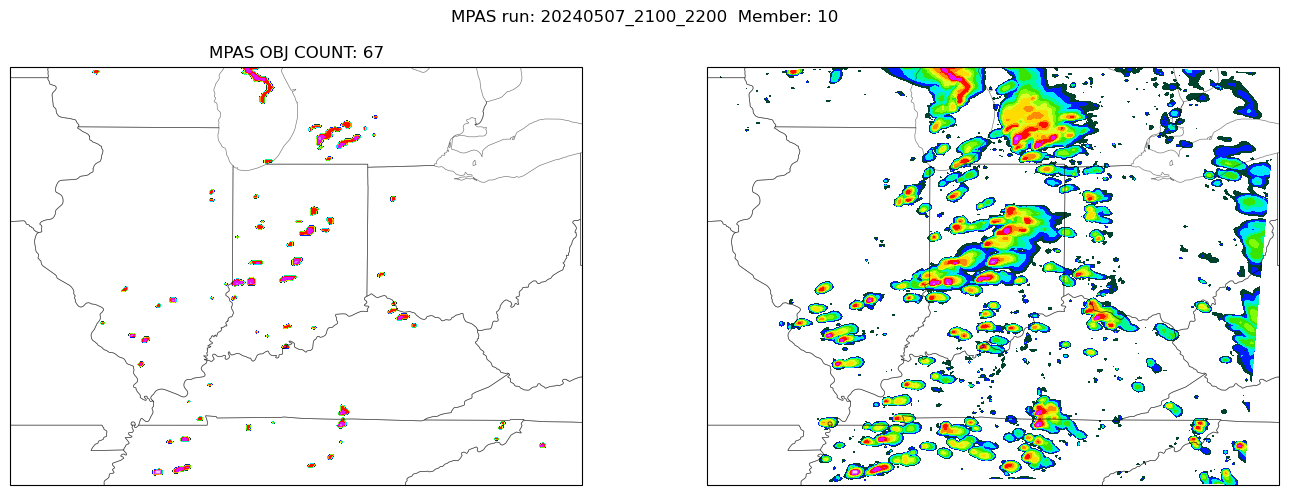

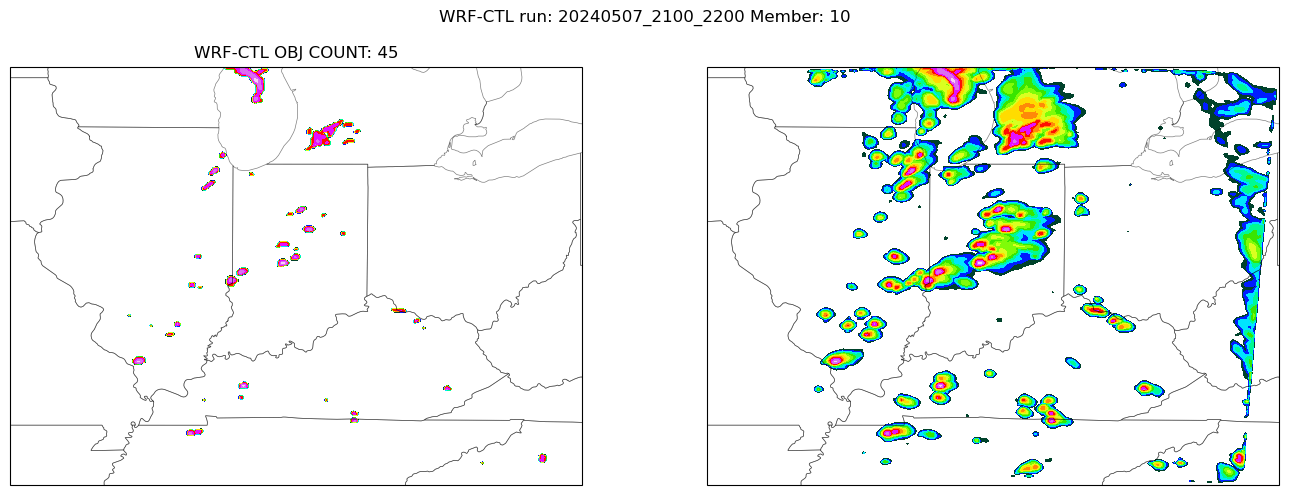

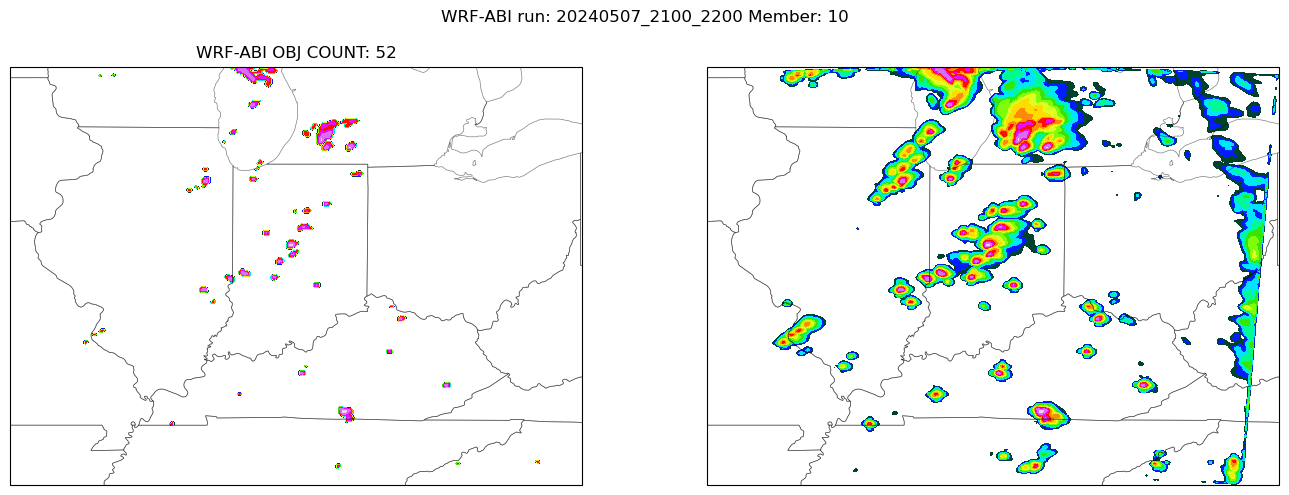

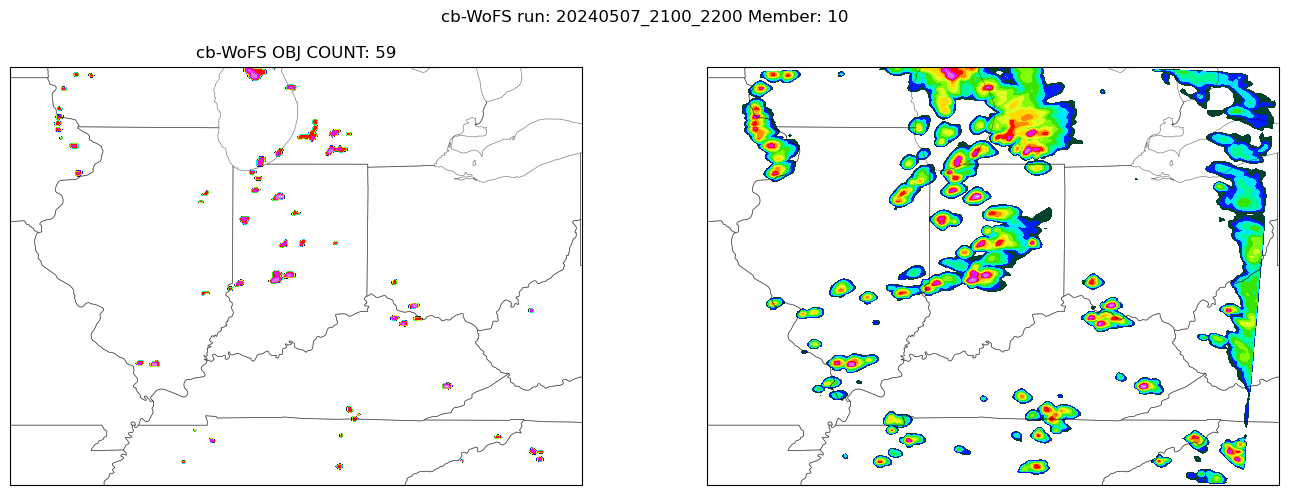

In [54]:
proj = ccrs.LambertConformal(central_longitude=-85.0, central_latitude=45.0)

n = 12
min = n*5
mem = 10

summary_mpas  = '/scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmncar/2100'
summary_wofs  = "/work2/Thomas.Jones/POST/summary_files/20240507_CTL_V3/2100"
summary_wofs2 = "/work2/Thomas.Jones/POST/summary_files/20240507_ABI_V3/2100"
summary_wofs3 = "/work2/wof/realtime/SummaryFiles/2024/WOFSRun20240507-132704d1/20240507/2100"

file_string = my_datetime([2024,5,7,21], time_delta=[0,0,min], summary_file=True)

# MPAS

ds = xr.open_dataset(os.path.join(summary_mpas, f"wofs_ALL_{n:02}_{file_string}.nc"))

mask_cref = np.where(ds['comp_dz'] > cref_thresh, ds['comp_dz'], 0.)

fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(17,5), subplot_kw={'projection': ccrs.PlateCarree()})
axs[0].contourf(ds.xlon, ds.xlat, mask_cref[mem], cmap='gist_ncar', levels=np.arange(5,75,5),transform=ccrs.PlateCarree())
axs[0].set_title(f"MPAS OBJ COUNT: {mpas_count[mem,n+1]}")
axs[1].contourf(ds.xlon, ds.xlat, ds.comp_dz[mem],cmap='gist_ncar',levels=np.arange(5,75,5), transform=ccrs.PlateCarree())
axs[0].add_feature(cfeature.STATES, linewidth=0.5, alpha=0.5)
axs[1].add_feature(cfeature.STATES, linewidth=0.5, alpha=0.5)
ds.close()
plt.suptitle(f"MPAS run: {file_string}  Member: {mem:02}")

# WRF CTL
ds = xr.open_dataset(os.path.join(summary_wofs, f"wofs_ALL_{n:02}_{file_string}.nc"))

mask_cref = np.where(ds['comp_dz'] > cref_thresh, ds['comp_dz'], 0.)

fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(17,5), subplot_kw={'projection': ccrs.PlateCarree()})
axs[0].contourf(ds.xlon, ds.xlat, mask_cref[mem], cmap='gist_ncar', levels=np.arange(5,75,5),transform=ccrs.PlateCarree())
axs[0].set_title(f"WRF-CTL OBJ COUNT: {wrf_count[mem,n+1]}")
axs[1].contourf(ds.xlon, ds.xlat, ds.comp_dz[mem],cmap='gist_ncar',levels=np.arange(5,75,5), transform=ccrs.PlateCarree())
axs[0].add_feature(cfeature.STATES, linewidth=0.5, alpha=0.5)
axs[1].add_feature(cfeature.STATES, linewidth=0.5, alpha=0.5)
ds.close()
plt.suptitle(f"WRF-CTL run: {file_string} Member: {mem:02}");

#WRF-ABI
ds = xr.open_dataset(os.path.join(summary_wofs2, f"wofs_ALL_{n:02}_{file_string}.nc"))

mask_cref = np.where(ds['comp_dz'] > cref_thresh, ds['comp_dz'], 0.)

fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(17,5), subplot_kw={'projection': ccrs.PlateCarree()})
axs[0].contourf(ds.xlon, ds.xlat, mask_cref[mem], cmap='gist_ncar', levels=np.arange(5,75,5),transform=ccrs.PlateCarree())
axs[0].set_title(f"WRF-ABI OBJ COUNT: {wrf_count2[mem,n+1]}")
axs[1].contourf(ds.xlon, ds.xlat, ds.comp_dz[mem],cmap='gist_ncar',levels=np.arange(5,75,5), transform=ccrs.PlateCarree())
axs[0].add_feature(cfeature.STATES, linewidth=0.5, alpha=0.5)
axs[1].add_feature(cfeature.STATES, linewidth=0.5, alpha=0.5)
ds.close()
plt.suptitle(f"WRF-ABI run: {file_string} Member: {mem:02}");

# cb-wofs
ds = xr.open_dataset(os.path.join(summary_wofs3, f"wofs_ALL_{n:02}_{file_string}.nc"))

mask_cref = np.where(ds['comp_dz'] > cref_thresh, ds['comp_dz'], 0.)

fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(17,5), subplot_kw={'projection': ccrs.PlateCarree()})
axs[0].contourf(ds.xlon, ds.xlat, mask_cref[mem], cmap='gist_ncar', levels=np.arange(5,75,5),transform=ccrs.PlateCarree())
axs[0].set_title(f"cb-WoFS OBJ COUNT: {wrf_count3[mem,n+1]}")
axs[1].contourf(ds.xlon, ds.xlat, ds.comp_dz[mem],cmap='gist_ncar',levels=np.arange(5,75,5), transform=ccrs.PlateCarree())
axs[0].add_feature(cfeature.STATES, linewidth=0.5, alpha=0.5)
axs[1].add_feature(cfeature.STATES, linewidth=0.5, alpha=0.5)
ds.close()
plt.suptitle(f"cb-WoFS run: {file_string} Member: {mem:02}");



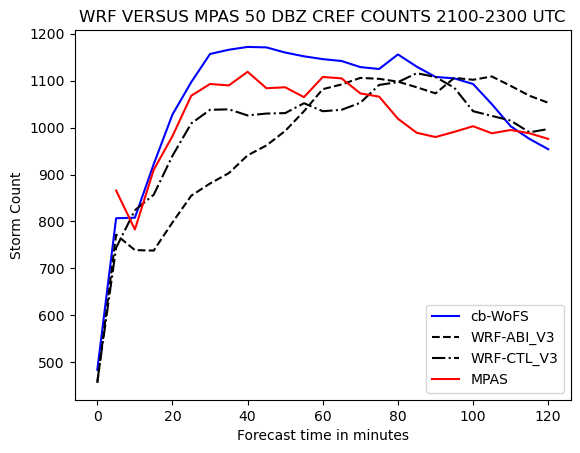

In [51]:
time = 5*np.arange(25)
plt.plot(time, wrf_count3.sum(axis=0), color='b', label='cb-WoFS')
plt.plot(time, wrf_count2.sum(axis=0), color='k', linestyle='--', label='WRF-ABI_V3')
plt.plot(time, wrf_count.sum(axis=0),  color='k', linestyle='-.', label='WRF-CTL_V3')
plt.plot(time[1:], mpas_count.sum(axis=0)[1:], color='r', label='MPAS')
plt.title("WRF VERSUS MPAS 50 DBZ CREF COUNTS 2100-2300 UTC")
plt.xlabel('Forecast time in minutes')
plt.ylabel('Storm Count')
plt.legend();